# Assignment 4: Peptide simulation
_Andreas Haraldsrud_

## Introduction
Here we will explore some properties of two tripeptides (AAA and APA) with MD simulations and visualization.


## 1. System properties

Let's first visualize the tripeptide AAA.

<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js"></script>

<script type="text/x-thebe-config">
{
    requestKernel: true,
    binderOptions: {
        repo: "binder-examples/requirements",
        ref: "master",
    },
}
</script>
<script src="https://unpkg.com/thebelab@latest/lib/index.js"></script>

<button id="activateButton" style="width: 120px; height: 40px; font-size: 1.5em;">
  Activate
</button>
<script>
var bootstrapThebe = function() {
    thebelab.bootstrap();
}
document.querySelector("#activateButton").addEventListener('click', bootstrapThebe)
</script>

<pre data-executable="true" data-language="python">

In [32]:
import nglview as nv

peptide = nv.show_file('MDrun/tripeptid2.pdb')
peptide

NGLWidget()

</pre>

We can see that the charge is neutral. This is because we added an acetyl group ($CH_3CO$) to one end and an N-methyl group ($NCH_3$) to not end up with "artificial" charges since this tripeptide most likely is a smaller fragment of a larger protein. Also, alanine does not have a charged side group. Each amino acid has a chiral center, so we have three chiral centras here. The three nitrogens and the three oxygens in the three amino acids each have (in principle) unpaireded electrons, but only oxygen can form hydrogen bonds as an H-bond acceptor. Nitrogen cannot act as an acceptor because its electrons are a part of the delocalized peptide bond. 

Also, the acetyl group has an oxygen and the N-methyl group has a nitrogen that can participate in hydrogen bonds as acceptors, because this nitrogen is not part of a peptide bond. In addition to this, H-bonds can form between the hydrogens (donors) on the three nitrogen atoms in the peptide, and a lone pair of an electronegative atom of another atom. So in principle a total of 9 H-bonds can be formed, where 7 of these are from the non-capped peptide. 

We can also visualize the cavity around the peptide with the MDAnalysis tool. From now on we visualize the peptide without the capping groups acetyl and N-methyl.

<pre data-executable="true" data-language="python">

In [11]:
from MDAnalysis import Universe

mda_traj500 = Universe('MDrun/topol.tpr', 'MDrun/trajcentred500ps.xtc')
mda_view = nv.show_mdanalysis(mda_traj500)
mda_view.clear_representations()
mda_view.add_representation(repr_type='ball+stick', selection='protein')
mda_view.add_representation(repr_type='spacefill', selection='water')
mda_view

NGLWidget(max_frame=500)

</pre>
We can see that the cavity extends below the protein, so that it's more cylindrical than spherical. A screenshot from VMD also confirms this:

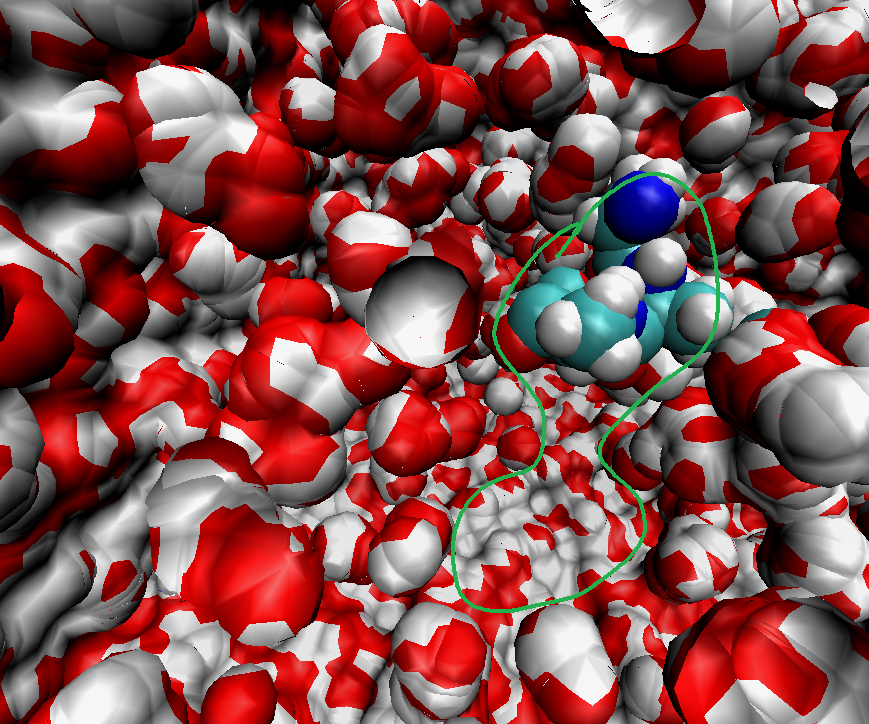

To verify that we have the right protein and to explore some other properties of the simulation, we can use some basic tools in MDAnalysis.

In [12]:
mda_traj500 = Universe('MDrun/topol.tpr', 'MDrun/trajcentred500ps.xtc')
protein = mda_traj500.atoms.select_atoms("protein")
uncapped_protein = list(protein[6:36])
solvshell = mda_traj500.atoms.select_atoms("resname SOL and around 5.0 protein") # Number of water molecules max 5.0 Å of the protein
residues = protein.residues # Find all residues in protein
protein_and_solvationshell = protein + solvshell

atom_names = protein.names # Display names of all atoms in the protein
charges = protein.charges # Find all charges of protein atoms
pos = protein.positions # Find positions (.velocities for velocities) of all protein atoms

print(f'Average water molecules in 5 Å solvation shell: {len(solvshell)}') 
print(f'Protein residues: {residues}')

Average water molecules in 5 Å solvation shell: 212
Protein residues: <ResidueGroup [<Residue ACE, 0>, <Residue ALA, 1>, <Residue ALA, 2>, <Residue ALA, 3>, <Residue NME, 4>]>


## 2. Energy and angles
We are running an MD simulation of the tripeptide in water with Gromacs, using the AMBER forcefield and the tip3p water model. The tripeptide is capped with acetyl and N-methyl to prevent ionic behavior of the zwitterion, as the tripeptide is meant to represent a small fragment of a larger protein. 

### 2.1 Equipartition theorem
The protein is geometry optimized and the energy is analyzed. According to the equipartition theorem, every degree of freedom should give $\frac{1}{2}k_bT$ of energy. Since our model uses 1 degree of vibrational freedom for the bonds, every of the 19 bonds should have this energy. This corresponds to roughly $0.5\cdot19\cdot k_bT \approx 24$ kJ/mol of energy. We can use the energy files from the simulation to plot and analyze the bond energies.

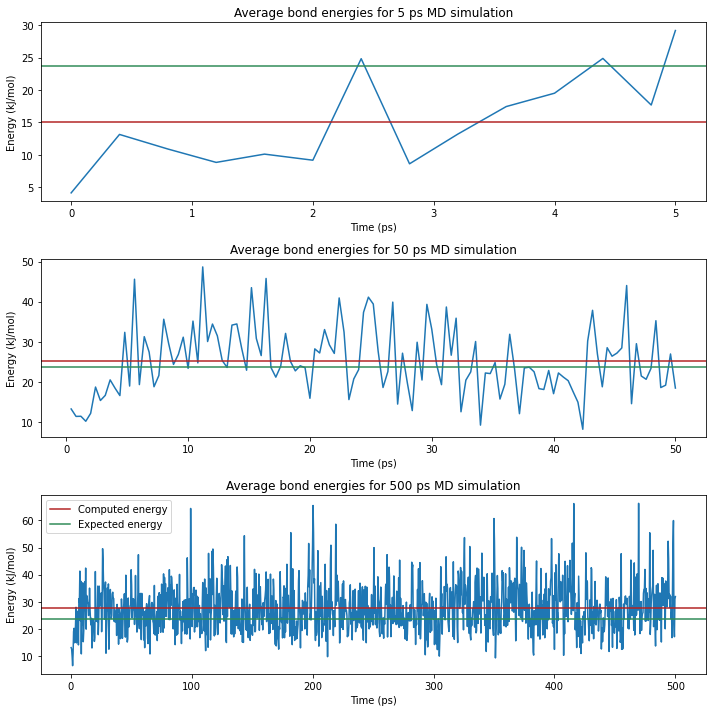

We expected 23.696210616933 kJ/mol according to the equipartition theorem.
The deviation from this was:
For t = 5 ps: 36.22 %
For t = 50 ps: 5.98 %
For t = 500 ps: 16.87 %


In [13]:
import numpy as np
import matplotlib.pyplot as plt

data5ps = np.loadtxt('Datafiles/energy5ps.xvg', skiprows=27)
time5 = data5ps [:,0]
bonds5 = data5ps [:,1]
avgbonds5 = np.mean(bonds5)

data50ps = np.loadtxt('Datafiles/energy50ps.xvg', skiprows=27)
time50 = data50ps [:,0]
bonds50 = data50ps [:,1]
avgbonds50 = np.mean(bonds50)

data500ps = np.loadtxt('Datafiles/energy500ps.xvg', skiprows=27)
time500 = data500ps [:,0]
bonds500 = data500ps [:,1]
avgbonds500 = np.mean(bonds500)

kb = 1.38064852E-23    # Boltzmann constant
bonds = 19             # Number of bonds
T = 300                # Temperature in K
N = 6.02214086E23      # Avogadro's constant
expected_energy = bonds*0.5*kb*N*T/1000 # kJ/mol

plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(time5,bonds5)
plt.title('Average bond energies for 5 ps MD simulation')
plt.xlabel('Time (ps)')
plt.ylabel('Energy (kJ/mol)')
plt.axhline(y=avgbonds5,color='firebrick', label='Computed energy')
plt.axhline(y = expected_energy,color='seagreen',label='Expected energy')

plt.subplot(3,1,2)
plt.plot(time50,bonds50)
plt.title('Average bond energies for 50 ps MD simulation')
plt.xlabel('Time (ps)')
plt.ylabel('Energy (kJ/mol)')
plt.axhline(y=avgbonds50,color='firebrick', label='Computed energy')
plt.axhline(y = expected_energy,color='seagreen',label='Expected energy')

plt.subplot(3,1,3)
plt.plot(time500,bonds500)
plt.title('Average bond energies for 500 ps MD simulation')
plt.xlabel('Time (ps)')
plt.ylabel('Energy (kJ/mol)')
plt.axhline(y=avgbonds500,color='firebrick', label='Computed energy')
plt.axhline(y = expected_energy,color='seagreen',label='Expected energy')

plt.legend()
plt.tight_layout()
plt.show()

print(f"We expected {expected_energy} kJ/mol according to the equipartition theorem.")
print("The deviation from this was:")
print(f"For t = 5 ps: {(abs(expected_energy - avgbonds5)/expected_energy*100):.2f} %")
print(f"For t = 50 ps: {abs(expected_energy - avgbonds50)/expected_energy*100:.2f} %")
print(f"For t = 500 ps: {abs(expected_energy - avgbonds500)/expected_energy*100:.2f} %")

What we see is that we actually get best fit to the theoretical energies with the 50 ps run. This might be random due to a relatively short run, and running several simulations for 50 ps should in principle make this clearer. What we see from comparing the run for 5 ps and 500 ps is that the deviation from the theoretical value tends to decrease as the simulation time increases. This illustrates the equipartition principle.

### 2.2 Dihedral angles

Let's now turn to the dihedral angles of the peptide. We can analyse the angles during the whole trajectory by using MDAnalysis' Dihedral and Ramachandran modules. The Ramachandran plot shows us all combinations of dihedrals in one plot. First we can compute a Ramachandran plot for the 500 ps run.

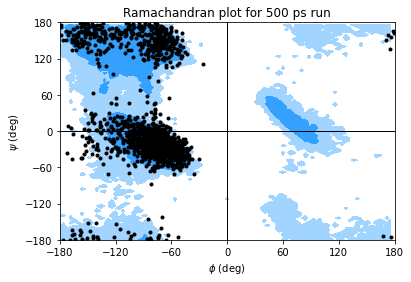

In [15]:
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran
import matplotlib.pyplot as plt

mda_traj500 = Universe('MDrun/topol.tpr', 'MDrun/trajcentred500ps.xtc')
r = Ramachandran(mda_traj500.select_atoms('protein')).run()
plt.title('Ramachandran plot for 500 ps run')
r.plot(color='black', marker='.', ref=True)

We plot the states of the backbone dihedral regions $\psi$ and $\phi$ in a Ramachandran plot. The allowed regions are marked in dark blue, and the marginally allowed regions marked in light blue. The data points are represented with black dots. We can see that, for the most part, the $\phi$ angles are found between –180$^\circ$ and –60$^\circ$, and that the $\psi$ angles occupy either 0$^\circ$ or $\pm$ 180$^\circ$. There are few states in the right region of the plot, and we see that even the allowed region where $\phi \approx 60^\circ$ and $\psi \approx 0^\circ$. We don't plot the $\omega$ bond, since it is mostly 180$^\circ$ because the partial double bond character of the peptide bond keeps the peptide planar. 

Let's repeat the analysis for the 50 and 5 ps trajectories.

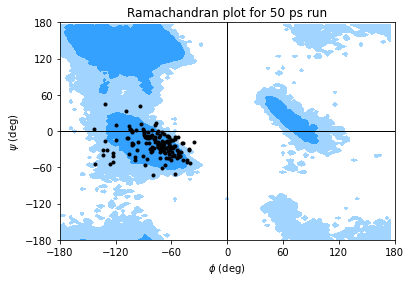

In [16]:
mda_traj50 = Universe('MDrun/topol.tpr', 'MDrun/trajcentred50ps.xtc')
r2 = Ramachandran(mda_traj50.select_atoms('protein')).run()
plt.title('Ramachandran plot for 50 ps run')
r2.plot(color='black', marker='.', ref=True)

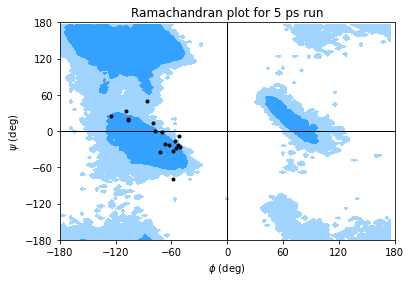

In [17]:
mda_traj5 = Universe('MDrun/topol.tpr', 'MDrun/trajcentred5ps.xtc')
r3 = Ramachandran(mda_traj5.select_atoms('protein')).run()
plt.title('Ramachandran plot for 5 ps run')
r3.plot(color='black', marker='.', ref=True)

We can see that in both the 5 and 50 ps run, the $\psi$ angle varies as 0 $\pm$ 60 and the $\phi$ angle varies as –90 $\pm$ 30.

We can illustrate ergodicity with these plots. The ergodic theorem states that the particles in a dynamic, statistical system will eventually visit all parts of the space that the system is allowed to move in. In this instance it will mean that the allowed regions in the Ramachandran plot should eventually be visited. We see that the number of configurations increases as the time increases, which illustrates the ergodic theorem. 

## 2.3 Angles for implicit solvent run
To illustrate this further, we can run a 20 ns (20 000 ps) simulation without solvent. We did this by removing the pressure coupling. This means that the box size is constant, so it won't shrink on the protein and cause numerical problems.

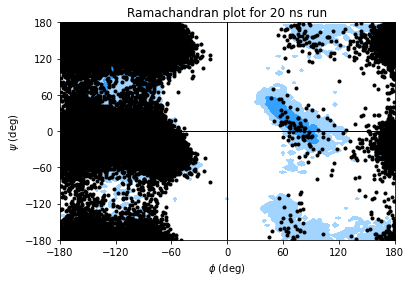

In [18]:
mda_traj20ns = Universe('MDrun/topol_without_water.tpr', 'MDrun/trajcentred20ns.xtc')
r4 = Ramachandran(mda_traj20ns.select_atoms('protein')).run()
plt.title('Ramachandran plot for 20 ns run')
r4.plot(color='black', marker='.', ref=True)

Here we see that additional states are occupied, even less likely states. This might be due to the fact that the peptide can rotate more freely because there are no water molecule to constrain it. We can observe this rapid changing of angles by visualizing the trajectory:

In [19]:
mda_view = nv.show_mdanalysis(mda_traj20ns)
mda_view.clear_representations()
mda_view.add_representation(repr_type='ball+stick', selection='protein')
mda_view

NGLWidget(max_frame=20000)

A histogram of both $\phi$ and $\psi$ will also be useful for understanding the distribution of each angle.

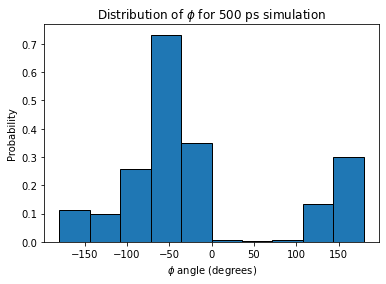

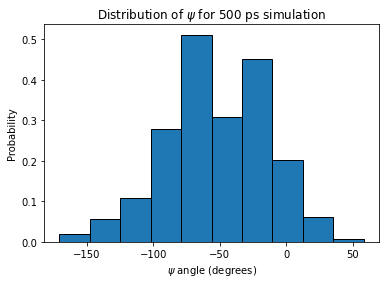

In [20]:
protein500 = mda_traj500.atoms.select_atoms("protein")
rama = Ramachandran(protein500.residues[1:4]).run()

phi = rama.angles[:,0]
psi = rama.angles[:,1]

hist_dist,bin_edges = np.histogram(phi)
probabilities_phi = hist_dist/len(phi)
plt.bar(bin_edges[:-1],probabilities_phi,width=[bin_edges[i+1]- bin_edges[i] for i in range(len(bin_edges)-1)],edgecolor='black',align='edge')
plt.title('Distribution of $\phi$ for 500 ps simulation')
plt.xlabel('$\phi$ angle (degrees)')
plt.ylabel('Probability')
plt.show()

hist_dist2,bin_edges2 = np.histogram(psi)
probabilities_psi = hist_dist2/len(psi)
plt.bar(bin_edges2[:-1],probabilities_psi,width=[bin_edges2[i+1]- bin_edges2[i] for i in range(len(bin_edges2)-1)],edgecolor='black',align='edge')
plt.title('Distribution of $\psi$ for 500 ps simulation')
plt.xlabel('$\psi$ angle (degrees)')
plt.ylabel('Probability')
plt.show()

We can also use the PMF (potential mean force $\mathcal{F}(\phi, \psi)$) rather than a probability distrubution for an observable (here: dihedrals). The probability distribution and the PMF are related by this expression:

$$P(\phi, \psi) = \frac{e^{-\beta\mathcal{F}(\phi, \psi)}}{Z(\beta)}$$

If we take the logarithm on each side, we have:

$$\mathcal{F}(\phi, \psi) = -kT \ln(P(\phi, \psi)Z(\beta)) = -kT \ln(P(\phi, \psi)) - kT\ln(Z(\beta))$$

Since $Z(\beta)$ is a constant at constant temperature, we can disregard this term (the zero of potential energy is arbitrary). We then have:

$$\mathcal{F}(\phi, \psi) = -kT \ln(P(\phi, \psi))$$

Since we can disregard the constant term, we just end up scaling all the probabilities equally. This results in the same Ramachandran plot as before:

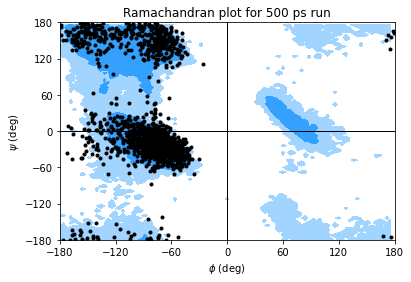

In [22]:
r = Ramachandran(mda_traj500.select_atoms('protein')).run()
plt.title('Ramachandran plot for 500 ps run')
r.plot(color='black', marker='.', ref=True)

## 2.4 Comparison with APA
Let's plot a Ramachandran plot for APA (alanine, proline, alanine) also. First we can visualize the peptide and the trajectories, and then we'll compute the angles.

In [23]:
import nglview as nv

peptide2 = nv.show_file('MDrun/APAtripeptide.pdb')
peptide2

NGLWidget()

In [24]:
mda_trajAPA = Universe('MDrun/topolAPA.tpr', 'MDrun/trajcentredAPA.xtc')
mda_view = nv.show_mdanalysis(mda_trajAPA)
mda_view.clear_representations()
mda_view.add_representation(repr_type='ball+stick', selection='protein')
mda_view.add_representation(repr_type='spacefill', selection='water')
mda_view

NGLWidget(max_frame=1000)

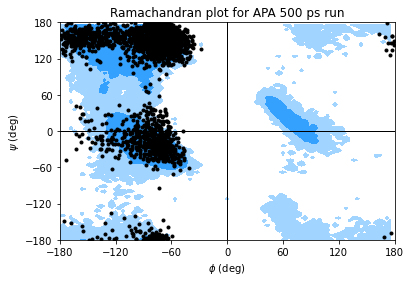

In [27]:
r5 = Ramachandran(mda_trajAPA.select_atoms('protein')).run()
plt.title('Ramachandran plot for APA 500 ps run')
r5.plot(color='black', marker='.', ref=True)

We can see that the distribution is quite similar as the AAA peptide. We should perhaps see less flexibility due to the ring in proline, so we'll run another 20 ns simulation and check the distribution again:

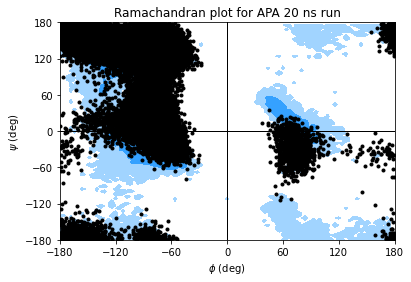

In [28]:
mda_trajAPA20ns = Universe('MDrun/topolAPA20ns.tpr', 'MDrun/trajcentredAPA20ns.xtc')
r6 = Ramachandran(mda_trajAPA20ns.select_atoms('protein')).run()
plt.title('Ramachandran plot for APA 20 ns run')
r6.plot(color='black', marker='.', ref=True)

We did not get particularly restricted angles as expected, but we got more angles centered around $\phi \approx 90 \pm 30$ and $\psi \approx 0 \pm 60$. Also the area for $\psi \approx -90 \pm 30$ seems to be more restricted than for the AAA-peptide.

## 2.5* Extra: Hydrogen bond analysis
We can also try to analyze the hydrogen bonds to understand for example the role H-bonds play in stabilizing the molecule.

In [33]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
from MDAnalysis.analysis import hbonds
import MDAnalysis
import MDAnalysis.analysis.hydrogenbonds.hbond_analysis

hbonds = HBA(universe = mda_traj500)
hbonds.hydrogens_sel = hbonds.guess_hydrogens("protein")
hbonds.acceptors_sel = hbonds.guess_acceptors("protein")
hbonds.run()

In [34]:
import numpy as np
number_of_hbonds_per_timestep = HBA.count_by_time(hbonds)
bonds_ace = HBA.count_by_type(hbonds)[0][2]
bonds_ala = HBA.count_by_type(hbonds)[1][2]
timestep = 0.002E-12
print(f'Average number of H-bonds per timestep: {np.mean(number_of_hbonds_per_timestep)}')
print(f'Maximum number of H-bonds per timestep: {max(number_of_hbonds_per_timestep)}')
print(f'Total number of H-bonds formed with O on alanines as donor: {bonds_ala}')

Average number of H-bonds per timestep: 3.9221556886227544
Maximum number of H-bonds per timestep: 8
Total number of H-bonds formed with O on alanines as donor: 1511


We can see that the average is about 4 bonds formed per timestep, and that we get a maximum of 8 bonds, which is not far from the 9 we expected. To get 9 we probably need to freeze the molecule in a perfect lattice with the water or simulate for a very long time.